# Imports

In [75]:
!pip install --quiet rouge-score
!pip install --quiet seaborn
!pip install --quiet sentence_transformers

In [76]:
from sentence_transformers import SentenceTransformer
import torch

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise
import numpy as np
from rouge_score import rouge_scorer

import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [77]:
df_base = pd.read_csv("resume_gemma.csv", index_col=0)
df_base = df_base.drop(['ft_gemma2_Q8_0', 'ft_gemma2_Q4_K_M'], axis=1) # not using them in benchmark
df_base.head()

,ID,Resume_str,Resume_html,Category,Resume_json,gemini_gen,base_gemma
0,36856210,INFORMATION TECHNOLOGY Summar...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY', 'summary': ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\..."
1,21780877,INFORMATION TECHNOLOGY SPECIALIST\tGS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY SPECIALIST GS...,"{\n ""name"": ""Kevin L. Trostle"",\n ""email"": n...","```json\n{\n ""name"": ""Kevin L. Trostle"",\n ""..."
2,33241454,INFORMATION TECHNOLOGY SUPERVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY SUPERVISOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\..."
3,25990239,INFORMATION TECHNOLOGY INSTRUCTOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY INSTRUCTOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\..."
4,16899268,INFORMATION TECHNOLOGY MANAGER/ANALYS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY MANAGER/ANALY...,"{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\..."


In [78]:
def fix_null_remove_json(text):
    text = re.sub(r'\bNone\b', 'null', text)
    control_chars = r"[\x00-\x08\x0B\x0C\x0E-\x1F\x7F\t\r]" 
    text = re.sub(control_chars, '', text)
    pattern = r"```json\s*([\s\S]*?)```"
    # pattern = r"<output>\s*([\s\S]*?)<output>"
    match = re.search(pattern, text)
    
    if match:
        return match.group(1).strip()
    else:
        return text

def json_load(text):
    try:
        return json.loads(fix_null_remove_json(text))
    except Exception as e:
        print(e)
        return None

In [79]:
df_base['gemini_gen_loaded'] = df_base['gemini_gen'].apply(json_load)
df_base['base_gemma_loaded'] = df_base['base_gemma'].apply(json_load)
df_base.head()

Expecting value: line 91 column 3 (char 2312)
Extra data: line 140 column 2 (char 8913)
Expecting value: line 1 column 1 (char 0)
Expecting ':' delimiter: line 98 column 39 (char 8010)
Invalid \escape: line 96 column 1224 (char 4007)
Invalid \escape: line 103 column 120 (char 5854)
Invalid \escape: line 208 column 31 (char 8370)
Expecting ',' delimiter: line 123 column 412 (char 7120)
Invalid \escape: line 100 column 271 (char 6502)
Expecting value: line 31 column 5 (char 1431)
Expecting value: line 1 column 1 (char 0)


,ID,Resume_str,Resume_html,Category,Resume_json,gemini_gen,base_gemma,gemini_gen_loaded,base_gemma_loaded
0,36856210,INFORMATION TECHNOLOGY Summar...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY', 'summary': ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
1,21780877,INFORMATION TECHNOLOGY SPECIALIST\tGS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY SPECIALIST GS...,"{\n ""name"": ""Kevin L. Trostle"",\n ""email"": n...","```json\n{\n ""name"": ""Kevin L. Trostle"",\n ""...","{'name': 'Kevin L. Trostle', 'email': None, 'p...","{'name': 'Kevin L. Trostle', 'phone': None, 'e..."
2,33241454,INFORMATION TECHNOLOGY SUPERVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY SUPERVISOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
3,25990239,INFORMATION TECHNOLOGY INSTRUCTOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY INSTRUCTOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
4,16899268,INFORMATION TECHNOLOGY MANAGER/ANALYS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY MANAGER/ANALY...,"{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."


In [80]:
df_base = df_base.dropna(axis=0)
df_base = df_base.reset_index(drop=True)
df_base.shape

(109, 9)

# Rogue Score:
- to measure content preservation

In [81]:
df_base['base_gemma_loaded'][0].keys()

dict_keys(['name', 'phone', 'email', 'linkedin', 'github', 'portfolio', 'summary', 'skill_section', 'education', 'work_experience', 'projects', 'certifications', 'achievements'])

In [82]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

skill_scores = []
work_exp_scores = []

for i in range(df_base.shape[0]):
    resume_txt = df_base['Resume_str'][i]
    gemma_skills_section = str(df_base['base_gemma_loaded'][i]['skill_section'])
    gemma_work_experience = str(df_base['base_gemma_loaded'][i]['work_experience'])
    skill_scores.append(scorer.score(resume_txt, gemma_skills_section))
    work_exp_scores.append(scorer.score(resume_txt, gemma_work_experience))

Rouge 1 scores:
{'skills': 0.9385292261597064, 'work_exp': 0.9032446714783833}
Rouge 2 scores:
{'skills': 0.7297256134847167, 'work_exp': 0.8267174153925515}
Rouge L scores:
{'skills': 0.7579687666763465, 'work_exp': 0.8590986539815698}


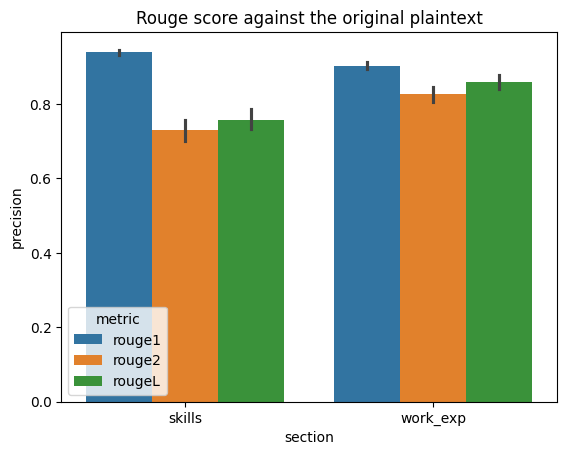

In [83]:
skills_df = pd.DataFrame(skill_scores)
work_exp_df = pd.DataFrame(work_exp_scores)

r1_scores = {
    'skills' : skills_df['rouge1'].str[0],
    'work_exp' : work_exp_df['rouge1'].str[0],
}

r2_scores = {
    'skills' : skills_df['rouge2'].str[0],
    'work_exp' : work_exp_df['rouge2'].str[0],
}

rL_scores = {
    'skills' : skills_df['rougeL'].str[0],
    'work_exp' : work_exp_df['rougeL'].str[0],
}

r1_scores_avg = {
    'skills' : sum([s['rouge1'].precision for s in skill_scores])/len(skill_scores),
    'work_exp' : sum([s['rouge1'].precision for s in work_exp_scores])/len(work_exp_scores),
}

r2_scores_avg = {
    'skills' : sum([s['rouge2'].precision for s in skill_scores])/len(skill_scores),
    'work_exp' : sum([s['rouge2'].precision for s in work_exp_scores])/len(work_exp_scores),
}

rL_scores_avg = {
    'skills' : sum([s['rougeL'].precision for s in skill_scores])/len(skill_scores),
    'work_exp' : sum([s['rougeL'].precision for s in work_exp_scores])/len(work_exp_scores),
}

print("Rouge 1 scores:")
print(r1_scores_avg)

print("Rouge 2 scores:")
print(r2_scores_avg)

print("Rouge L scores:")
print(rL_scores_avg)

r1_df = pd.DataFrame(r1_scores)
r1_df['metric'] = 'rouge1'
r2_df = pd.DataFrame(r2_scores)
r2_df['metric'] = 'rouge2'
rL_df = pd.DataFrame(rL_scores)
rL_df['metric'] = 'rougeL'

score_df = pd.concat([r1_df, r2_df, rL_df])
score_df = score_df.melt(id_vars=['metric'], var_name='section', value_name='precision')
sns.barplot(score_df, x='section', y='precision', hue='metric')
plt.title("Rouge score against the original plaintext")
plt.show()

# Cosine Similarity

In [84]:
df_base.head()

,ID,Resume_str,Resume_html,Category,Resume_json,gemini_gen,base_gemma,gemini_gen_loaded,base_gemma_loaded
0,36856210,INFORMATION TECHNOLOGY Summar...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY', 'summary': ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
1,21780877,INFORMATION TECHNOLOGY SPECIALIST\tGS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY SPECIALIST GS...,"{\n ""name"": ""Kevin L. Trostle"",\n ""email"": n...","```json\n{\n ""name"": ""Kevin L. Trostle"",\n ""...","{'name': 'Kevin L. Trostle', 'email': None, 'p...","{'name': 'Kevin L. Trostle', 'phone': None, 'e..."
2,33241454,INFORMATION TECHNOLOGY SUPERVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY SUPERVISOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
3,25990239,INFORMATION TECHNOLOGY INSTRUCTOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY INSTRUCTOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
4,16899268,INFORMATION TECHNOLOGY MANAGER/ANALYS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY MANAGER/ANALY...,"{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."


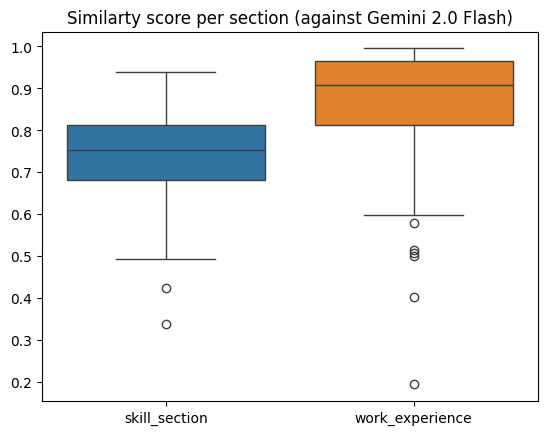

In [85]:
# embedder = SentenceTransformer("sentence-transformers/bert-large-nli-cls-token")
embedder = SentenceTransformer("sentence-transformers/all-roberta-large-v1")
similarity_scores = {}

skills_str_gemma = []
work_exp_str_gemma = []
skills_str_gemini= []
work_exp_str_gemini = []
for i in range(df_base.shape[0]):
    skills_str_gemma.append(str(df_base['base_gemma_loaded'][i]['skill_section']))
    work_exp_str_gemma.append(str(df_base['base_gemma_loaded'][i]['work_experience']))
    
    skills_str_gemini.append(str(df_base['gemini_gen_loaded'][i]['skill_section']))
    work_exp_str_gemini.append(str(df_base['gemini_gen_loaded'][i]['work_experience']))
    
skills_emb_gemma = embedder.encode(skills_str_gemma)
work_exp_emb_gemma = embedder.encode(work_exp_str_gemma)
skills_emb_gemini = embedder.encode(skills_str_gemini)
work_exp_emb_gemini = embedder.encode(work_exp_str_gemini)

similarity_scores["skill_section"] = torch.diagonal(embedder.similarity(skills_emb_gemma, skills_emb_gemini), 0)
similarity_scores["work_experience"] = torch.diagonal(embedder.similarity(work_exp_emb_gemma, work_exp_emb_gemini), 0)

sns.boxplot(similarity_scores)
plt.title("Similarty score per section (against Gemini 2.0 Flash)")
plt.show()